In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imshow

import tensorflow as tf
from tensorflow import keras

In [2]:
train_data_path = "../input/stage1_train/"
image_size = 256

train_ids = next(os.walk(train_data_path))[1]

x_train = np.zeros((len(train_ids),image_size, image_size, 3), dtype = np.uint8)
y_train = np.zeros((len(train_ids),image_size, image_size, 1))

for i, id_ in enumerate(train_ids):
    image_path = train_data_path+"{}/images/{}".format(id_,id_)
    img = cv2.imread(image_path+".png", 1)
    img = cv2.resize(img, (image_size, image_size))
    x_train[i] = img
    
    height, width, _ = img.shape
    label = np.zeros((height, width, 1))
    mask_path = train_data_path+"{}/masks/".format(id_)
    for mask_file in next(os.walk(mask_path))[2]:
        mask = cv2.imread(mask_path+mask_file, 0)
        mask = cv2.resize(mask, (image_size, image_size))
        mask = np.expand_dims(mask, axis=-1)
        label = np.maximum(label, mask)
    y_train[i] = label

In [3]:
test_data_path = "../input/stage1_test/"

test_ids=next(os.walk(test_data_path))[1]
x_test = np.zeros((len(test_ids), image_size, image_size, 3), dtype=np.uint8)
test_sizes = []
for i, id_ in enumerate(test_ids):
    test_image_path = test_data_path+"{}/images/{}".format(id_,id_)
    test_image = cv2.imread(test_image_path+".png", 1)
    test_sizes.append([test_image.shape[0], test_image.shape[1]])
    test_image = cv2.resize(test_image, (image_size, image_size))
    x_test[i]=test_image

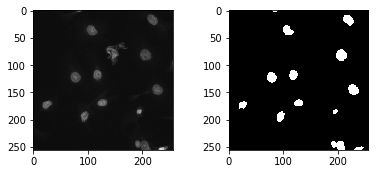

In [4]:
r = random.randint(0, len(x_train)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x_train[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y_train[r]*255, (image_size, image_size)), cmap="gray")

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range=30,
                              height_shift_range=0.3,
                              zoom_range=0.3,
                              horizontal_flip=True,
                              width_shift_range=0.3,
                              fill_mode='reflect')

val_gen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import train_test_split

xt, xv, yt, yv = train_test_split(x_train, y_train, test_size=0.2)

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


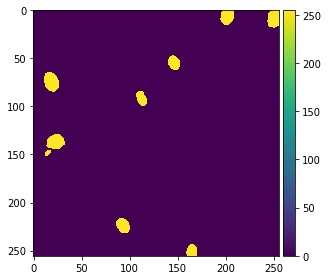

In [7]:
y = yv[22][:,:,0]
imshow(y)
plt.show()

In [8]:
print(xt.shape)
print(len(yt))
print(len(xv))
print(yv.shape)

(536, 256, 256, 3)
536
134
(134, 256, 256, 1)


In [9]:
seed=42
def combineGenerator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())

train_generator_image = train_gen.flow(xt,batch_size=16, seed=seed, shuffle=True)
train_generator_mask = train_gen.flow(yt, batch_size=16, seed=seed, shuffle=True)
train_generator = combineGenerator(train_generator_image, train_generator_mask)
validation_generator_image = val_gen.flow(xv, batch_size=16, seed=seed, shuffle=True)
validation_generator_mask = val_gen.flow(yv, batch_size=16, seed=seed, shuffle=True)
validation_generator = combineGenerator(validation_generator_image, validation_generator_mask)

In [10]:
a, b = next(validation_generator)
print(a.shape, b.shape)

(16, 256, 256, 3) (16, 256, 256, 1)


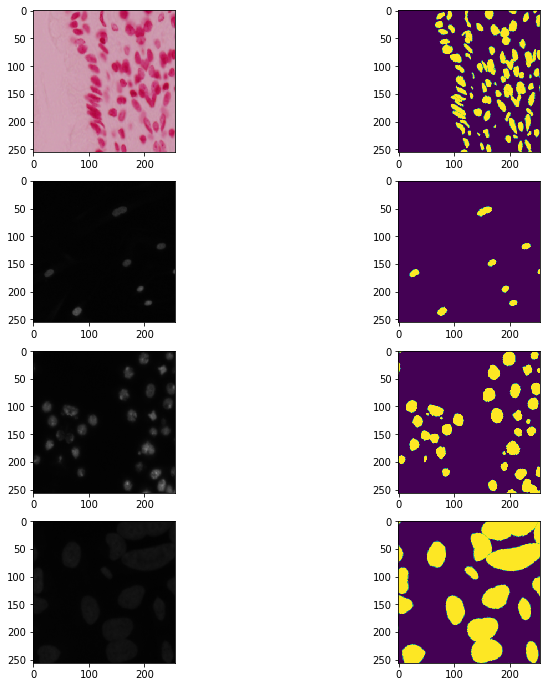

In [11]:
img1, mask1 = next(train_generator)

fig=plt.figure(figsize=(12,12))
columns = 2
rows = 4
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c = c + 1
    counter = counter + 1
    
plt.show()

In [12]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act==True:
        x = keras.layers.Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3,3), padding='same', strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1,1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    conv = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1,1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, conv])
    return output

def up_sampling_concat_block(x, x_skip):
    up_sample = keras.layers.UpSampling2D((2,2))(x)
    concat = keras.layers.Concatenate()([up_sample, x_skip])
    return concat
    

In [13]:
def ResUnet():
    f = [16,32,64,128,256]
    img_=256
    inputs = keras.layers.Input((img_, img_,3))
    
    #encoding
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    #bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    #decoder
    u0 = up_sampling_concat_block(b1, e4)
    d0 = residual_block(u0, f[4])
    
    u1 = up_sampling_concat_block(d0, e3)
    d1 = residual_block(u1, f[3])
    
    u2 = up_sampling_concat_block(d1, e2)
    d2 = residual_block(u2, f[2])
    
    u3 = up_sampling_concat_block(d2, e1)
    d3 = residual_block(u3, f[1])
    
    output = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(d3)
    model = keras.models.Model(inputs, output)
    return model

In [14]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [62]:
from tensorflow.python.keras.optimizers import adam

model = ResUnet()
model.compile(optimizer=adam(lr=0.0005), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 256, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_140 (Bat (None, 256, 256, 16) 64          conv2d_150[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 256, 256, 16) 0           batch_normalization_v1_140[0][0] 
__________________________________________________________________________________________________
conv2d_152

In [63]:
from tensorflow.keras.callbacks import  ModelCheckpoint

callbacks=[ModelCheckpoint(monitor='val_loss',
                             filepath='dsb.h5',
                             save_best_only=True)]
train_steps = len(xt)//16
val_steps = len(xv)//16
history = model.fit_generator(train_generator, steps_per_epoch = train_steps, epochs = 20,
                              validation_data = validation_generator, validation_steps = val_steps, callbacks=callbacks)

Epoch 1/30
33/33 [==============================] - 86s 3s/step - loss: 0.3183 - dice_coef: 0.6817 - val_loss: 0.7925 - val_dice_coef: 0.2075
Epoch 2/30
33/33 [==============================] - 9s 286ms/step - loss: 0.2621 - dice_coef: 0.7376 - val_loss: 0.7876 - val_dice_coef: 0.2124
Epoch 3/30
33/33 [==============================] - 11s 328ms/step - loss: 0.2113 - dice_coef: 0.7887 - val_loss: 0.9643 - val_dice_coef: 0.0357
Epoch 4/30
33/33 [==============================] - 11s 345ms/step - loss: 0.2036 - dice_coef: 0.7965 - val_loss: 0.7853 - val_dice_coef: 0.2147
Epoch 5/30
33/33 [==============================] - 11s 328ms/step - loss: 0.1726 - dice_coef: 0.8274 - val_loss: 0.9947 - val_dice_coef: 0.0053
Epoch 6/30
33/33 [==============================] - 11s 331ms/step - loss: 0.1764 - dice_coef: 0.8237 - val_loss: 0.9677 - val_dice_coef: 0.0323
Epoch 7/30
33/33 [==============================] - 11s 331ms/step - loss: 0.1652 - dice_coef: 0.8348 - val_loss: 0.9911 - val_dice_co

In [46]:
model = keras.models.load_model('dsb.h5', custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})
test_mask = model.predict(x_test, verbose=1)

65/65 [==============================] - 1s 21ms/sample


In [65]:
test_mask[0].shape

(256, 256, 1)

In [47]:
preds_test_t = (test_mask > 0.5).astype(np.uint8)

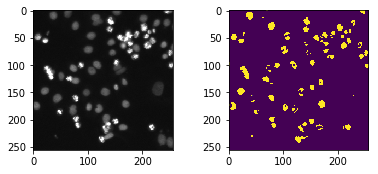

In [69]:
r = random.randint(0, len(x_test)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x_test[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(test_mask[r][:,:,0])

In [54]:
from skimage.morphology import label
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [50]:
from skimage.transform import resize

preds_test_upsampled = []
for i in range(len(test_mask)):
    preds_test_upsampled.append(resize(np.squeeze(test_mask[i]), 
                                       (test_sizes[i][0], test_sizes[i][1]), 
                                       mode='constant', preserve_range=True))

In [71]:
preds_test_upsampled[0].shape

(256, 256)

In [74]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.append(rle)
    new_test_ids.append([id_] * len(rle))

In [78]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('dsb2k18_01.csv', index=False)